In [1]:
import sys
sys.path.insert(1, '/home/mamur/TUM/ADLM/')

In [2]:
import numpy as np
import pandas as pd
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
from tqdm.notebook import tqdm
from pathlib import Path
from collections import Counter


tqdm.pandas()

## Vertebal Column

The spine is made up of bones, muscles, tendons, nerves, and other tissues that reach from the base of the skull near the spinal cord (clivus) to the coccyx (tailbone). The vertebrae (back bones) of the spine include the cervical spine (C1-C7), thoracic spine (T1-T12), lumbar spine (L1-L5), sacral spine (S1-S5), and the tailbone. Each vertebra is separated by a disc. The vertebrae surround and protect the spinal cord.

In [3]:
from IPython.display import display, HTML
display(HTML("<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/Gray_111_-_Vertebral_column-coloured.png/174px-Gray_111_-_Vertebral_column-coloured.png'></center>"))


## Lumbar Vertebra
The lumbar vertebrae are, in human anatomy, the five vertebrae between the rib cage and the pelvis. They are the largest segments of the vertebral column and are characterized by the absence of the foramen transversarium within the transverse process (since it is only found in the cervical region) and by the absence of facets on the sides of the body (as found only in the thoracic region). They are designated L1 to L5, starting at the top. The lumbar vertebrae help support the weight of the body, and permit movement.

## Tests and Imaging
Computed tomography (CT) scan: This scan uses X-rays and computers to produce images that are very thin “slices” of the area under examination. A CT scan can show the shape and size of your spinal canal, its contents and the bone around it. It helps diagnose bone spurs, osteophytes, bone fusion and bone destruction from infection or tumor.

## Dataset - VerSe
Spine or vertebral segmentation is a crucial step in all applications regarding automated quantification of spinal morphology and pathology. With the advent of deep learning, for such a task on computed tomography (CT) scans, a big and varied data is a primary sought-after resource. However, a large-scale, public dataset is currently unavailable.

We believe VerSe can help here. VerSe is a large scale, multi-detector, multi-site, CT spine dataset consisting of 374 scans from 355 patients. The challenge was held in two iterations in conjunction with MICCAI 2019 and 2020. The tasks evaluated for include: vertebral labelling and segmentation.

In [4]:
from IPython.display import display, HTML
display(HTML("<center><img src='https://github.com/anjany/verse/blob/main/assets/dataset_snapshot.png?raw=true'></center>"))


## Uderstanding Derivatives
1) seg-subreg-ctd.json
2) seg-subreg-mask.nii.gz
3) seg-total-mask.nii.gz
4) seg-vertsac-ctd.json
5) seg-vertsac-mask.nii.gz

In [5]:
v_idx2name = {
     1: "C1",     2: "C2",     3: "C3",     4: "C4",     5: "C5",     6: "C6",     7: "C7", 
     8: "T1",     9: "T2",    10: "T3",    11: "T4",    12: "T5",    13: "T6",    14: "T7",    15: "T8",    16: "T9",    17: "T10",   18: "T11",   19: "T12", 28: "T13",
    20: "L1",    21: "L2",    22: "L3",    23: "L4",    24: "L5",    25: "L6",    
    26: "S1",    29: "S2",    30: "S3",    31: "S4",    32: "S5",    33: "S6",
    27: "Cocc",
}

In [6]:
master_df = pd.read_excel('/home/mamur/TUM/ADLM/3D-Castellvi-Prediction/dataset/VerSe_masterlist.xlsx')
master_df
master_df = master_df[['Id', 'Full_Id', 'Castellvi', '2a/3a Side',	'Sacrum Seg', 'Last_L']]

In [7]:
master_df.head()

,Id,Full_Id,Castellvi,2a/3a Side,Sacrum Seg,Last_L
0,4,sub-verse004,0,NaN,1.0,L5
1,5,sub-verse005,0,NaN,1.0,L5
2,6,sub-verse006,0,NaN,1.0,L5
3,7,NaN,NaN,NaN,NaN,NaN
4,8,sub-verse008,0,NaN,1.0,L5


In [8]:
print('missing image derivatives: ', master_df.Full_Id.isna().sum())

missing image derivatives:  40


In [9]:
master_df = master_df.dropna(subset=['Full_Id'])

In [10]:
master_df

,Id,Full_Id,Castellvi,2a/3a Side,Sacrum Seg,Last_L
0,4,sub-verse004,0,NaN,1.0,L5
1,5,sub-verse005,0,NaN,1.0,L5
2,6,sub-verse006,0,NaN,1.0,L5
4,8,sub-verse008,0,NaN,1.0,L5
5,9,sub-verse009,0,NaN,1.0,L5
...,...,...,...,...,...,...
320,824,sub-verse824,0,NaN,1.0,L5
321,825,sub-verse825,0,NaN,1.0,L5
322,826,sub-verse826,0,NaN,1.0,L5
323,833,sub-verse833,2b,NaN,1.0,L5


In [11]:
verse19 = '/home/mamur/TUM/ADLM/dataset-verse19/'
verse20 = '/home/mamur/TUM/ADLM/dataset-verse20/'
def get_full_idx(root):
    root = root + 'derivatives/'    
    full_idx = os.listdir(root)
    return full_idx

dataset_19 = get_full_idx(verse19)
dataset_20 = get_full_idx(verse20)
full_idx = get_full_idx(verse19) + get_full_idx(verse20)


In [12]:
print('dataset size:', len(full_idx))

dataset size: 323


In [13]:
def find_missing_derivatives(list1, list2):
    # Find elements present in list1 but not in list2
    missing_in_list2 = [item for item in list1 if item not in list2]

    # Find elements present in list2 but not in list1
    missing_in_list1 = [item for item in list2 if item not in list1]

    return missing_in_list1, missing_in_list2

In [14]:
list1 = list(master_df['Full_Id'])
list2 = full_idx

missing_in_list1, missing_in_list2 = find_missing_derivatives(list1, list2)
print("Missing in list1:", len(missing_in_list1))
print("Missing in list2:", len(missing_in_list2))


Missing in list1: 56
Missing in list2: 18


In [15]:
missing_in_list1

['sub-verse410',
 'sub-verse205',
 'sub-verse105',
 'sub-verse081',
 'sub-verse403',
 'sub-verse221',
 'sub-verse404',
 'sub-verse007',
 'sub-verse412',
 'sub-verse401',
 'sub-verse402',
 'sub-verse405',
 'sub-verse400',
 'sub-verse112',
 'sub-verse415',
 'sub-verse413',
 'sub-verse075',
 'sub-verse018',
 'sub-verse012',
 'sub-verse416',
 'sub-verse119',
 'sub-verse125',
 'sub-verse242',
 'sub-verse217',
 'sub-verse207',
 'sub-verse225',
 'sub-verse411',
 'sub-verse409',
 'sub-verse407',
 'sub-verse100',
 'sub-verse406',
 'sub-verse408',
 'sub-verse011',
 'sub-verse150',
 'sub-verse414',
 'sub-verse059',
 'sub-verse250',
 'sub-verse417',
 'sub-verse230',
 'sub-verse643',
 'sub-verse814',
 'sub-verse645',
 'sub-verse650',
 'sub-verse803',
 'sub-verse641',
 'sub-verse647',
 'sub-verse767',
 'sub-verse757',
 'sub-verse710',
 'sub-verse596',
 'sub-verse544',
 'sub-verse648',
 'sub-verse764',
 'sub-verse651',
 'sub-verse640',
 'sub-verse754']

In [16]:
missing_in_list2

['sub-verse400_split-verse155',
 'sub-verse401_split-verse253',
 'sub-verse402_split-verse251',
 'sub-verse403_split-verse255',
 'sub-verse404_split-verse256',
 'sub-verse405_split-verse259',
 'sub-verse406_split-verse261',
 'sub-verse407_split-verse262',
 'sub-verse408_split-verse265',
 'sub-verse409_split-verse266',
 'sub-verse410_split-verse267',
 'sub-verse411_split-verse270',
 'sub-verse412_split-verse290',
 'sub-verse413_split-verse272',
 'sub-verse414_split-verse273',
 'sub-verse415_split-verse275',
 'sub-verse416_split-verse279',
 'sub-verse417_split-verse278']

In [17]:
# Uncomment to make it optimized

# start_of_20 = sorted(dataset_20)
# idx_arr = start_of_20[0].split('verse')
# first_idx_20 = idx_arr[-1]
# print(first_idx_20)

## Understanding the CT Scans

In [18]:
# As mentioned above we have 323 study IDs

In [19]:
from IPython.display import display, HTML
display(HTML("<center><img src='https://www.ipfradiologyrounds.com/_images/image-reconstruction-planes.png?raw=true'></center>"))




## Create Reference Dataframe

In [20]:
master_df

,Id,Full_Id,Castellvi,2a/3a Side,Sacrum Seg,Last_L
0,4,sub-verse004,0,NaN,1.0,L5
1,5,sub-verse005,0,NaN,1.0,L5
2,6,sub-verse006,0,NaN,1.0,L5
4,8,sub-verse008,0,NaN,1.0,L5
5,9,sub-verse009,0,NaN,1.0,L5
...,...,...,...,...,...,...
320,824,sub-verse824,0,NaN,1.0,L5
321,825,sub-verse825,0,NaN,1.0,L5
322,826,sub-verse826,0,NaN,1.0,L5
323,833,sub-verse833,2b,NaN,1.0,L5


In [21]:
ct_paths = []
ctd_paths = []
vert_paths = []

for i in master_df.Full_Id:
    if 'split' in i:
        file_name_arr = i.split('_')
        file_name = file_name_arr[0]
    else:
        file_name = i

    if file_name in sorted(dataset_19):
        root = "../../dataset-verse19/"
    elif file_name in sorted(dataset_20):
        root = '../../dataset-verse20/'
    else:
        raise Exception('File not found')
    
    raw_data_path = Path(root, 'rawdata/' + file_name + '/')
    if os.path.exists(raw_data_path):
        raw_datas = os.listdir(raw_data_path)
        ct_path = [filename for filename in raw_datas if 'ct' in filename]
        full_ct_path = raw_data_path.joinpath(ct_path[0])
        if os.path.exists(full_ct_path):
            ct_abs_path = full_ct_path
        else:
            ct_abs_path = 'None'
    else:
        ct_abs_path = 'None'
    ct_paths.append(ct_abs_path)

    derivative_path = Path(root, 'derivatives/' + file_name + '/')
    if os.path.exists(derivative_path):
        derivatives = os.listdir(derivative_path)
        vert_path = [filename for filename in derivatives if 'seg-vert' in filename and 'seg-vertsac' not in filename]
        ctd_path = [filename for filename in derivatives if 'subreg_ctd' in filename]
        full_vert_path = derivative_path.joinpath(vert_path[0])
        if os.path.exists(full_vert_path):
            vert_abs_path = full_vert_path
        else:
            vert_abs_path = 'None'

        full_ctd_path = derivative_path.joinpath(ctd_path[0])
        if os.path.exists(full_ctd_path):
            ctd_abs_path = full_ctd_path
        else:
            ctd_abs_path = 'None'
    vert_paths.append(vert_abs_path)
    ctd_paths.append(ctd_abs_path)


In [22]:
master_df['ct_path'] = ct_paths
master_df['vert_path'] = vert_paths
master_df['ctd_path'] = ctd_paths

In [23]:
master_df = master_df.replace({'None': np.nan})


In [24]:
df = master_df.copy()

In [25]:


# Specify the columns you want to check for NaN values
columns_to_check = ['ct_path', 'vert_path', 'ctd_path']

# Check if any element in the specified columns is NaN
nan_rows = df[df[columns_to_check].isna().any(axis=1)]

len(nan_rows)


56

In [28]:
import plotly.express as px

# Specify the columns you want to check for NaN values
columns_to_check = ['ct_path', 'vert_path', 'ctd_path']

# Check if any element in the specified columns is NaN
nan_rows = df[df[columns_to_check].isna().any(axis=1)]

# Count the number of NaN values in each column
nan_counts = nan_rows[columns_to_check].isna().sum().reset_index()

# Rename columns for better readability
nan_counts.columns = ['column', 'nan_count']

# Create the pie chart
fig = px.pie(nan_counts,
             names='column',
             values='nan_count',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             title='Missing images'
            ).update_traces(textinfo='label+percent')

# Display the chart
fig.show()


## Feature Engineering

In [31]:
import pandas as pd
import plotly.express as px

# Assuming your DataFrame is named `df`
# Calculate the count of Last_L values for the entire dataset
last_l_counts = df['Last_L'].value_counts().reset_index()

# Rename columns for better readability
last_l_counts.columns = ['Last_L', 'Count']

# Create the pie chart
fig = px.pie(last_l_counts,
             names='Last_L',
             values='Count',
             title='Last_L Value Distribution',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             ).update_traces(textinfo='label+percent')

fig.show()

In [30]:
import pandas as pd
import plotly.express as px

# Assuming your DataFrame is named `df`
# Filter the rows with Castellvi different than 0
castellvi_nonzero = df[df['Castellvi'] != 0]

# Filter the rows with Castellvi equal to 0
castellvi_zero = df[df['Castellvi'] == 0]

# Calculate the count of Last_L values for each group
castellvi_nonzero_count = castellvi_nonzero['Last_L'].value_counts().reset_index()
castellvi_zero_count = castellvi_zero['Last_L'].value_counts().reset_index()

# Rename columns for better readability
castellvi_nonzero_count.columns = ['Last_L', 'Nonzero_Castellvi_Count']
castellvi_zero_count.columns = ['Last_L', 'Zero_Castellvi_Count']

# Merge the two count DataFrames on the Last_L column
merged_counts = pd.merge(castellvi_nonzero_count, castellvi_zero_count, on='Last_L')

# Create the bar chart
fig = px.bar(merged_counts,
             x='Last_L',
             y=['Nonzero_Castellvi_Count', 'Zero_Castellvi_Count'],
             title='Last_L Value Count for Binary Anomaly Classification',
             color_discrete_sequence=['#e0465f', '#afde2c'],
             labels={'value': 'Count', 'variable': 'Castellvi Group'},
             )

fig.show()


In [34]:
import pandas as pd
import plotly.express as px

# Assuming your DataFrame is named `df`
# Group by Castellvi and Last_L values and calculate the count
grouped_counts = df.groupby(['Castellvi', 'Last_L']).size().reset_index(name='Count')

# Rename columns for better readability
grouped_counts.columns = ['Castellvi', 'Last_L', 'Count']

# Create the grouped bar chart
fig = px.bar(grouped_counts,
             x='Last_L',
             y='Count',
             color='Castellvi',
             barmode='group',
             title='Last_L Value Count for Each Castellvi Category',
             labels={'Castellvi': 'Castellvi Value'},
             )

fig.show()


In [32]:
import pandas as pd
import plotly.express as px

# Assuming your DataFrame is named `df`
# Group by Last_L and Sacrum Seg values and calculate the count
grouped_counts = df.groupby(['Last_L', 'Sacrum Seg']).size().reset_index(name='Count')

# Rename columns for better readability
grouped_counts.columns = ['Last_L', 'Sacrum Seg', 'Count']

# Create the stacked bar chart
fig = px.bar(grouped_counts,
             x='Last_L',
             y='Count',
             color='Sacrum Seg',
             title='Sacrum Seg Value Count for Each Last_L Value',
             labels={'Sacrum Seg': 'Sacrum Seg Value'},
             )

fig.show()


## BIDS Toolbox & ROI

In [41]:
sys.path.insert(2, '/home/mamur/TUM/ADLM/3D-Castellvi-Prediction/bids/')

In [42]:
from BIDS.snapshot2D import create_snapshot,Snapshot_Frame,Visualization_Type,Image_Modes
from pathlib import Path
from IPython.display import Image

[*] Snapshot saved: /tmp/out.jpg


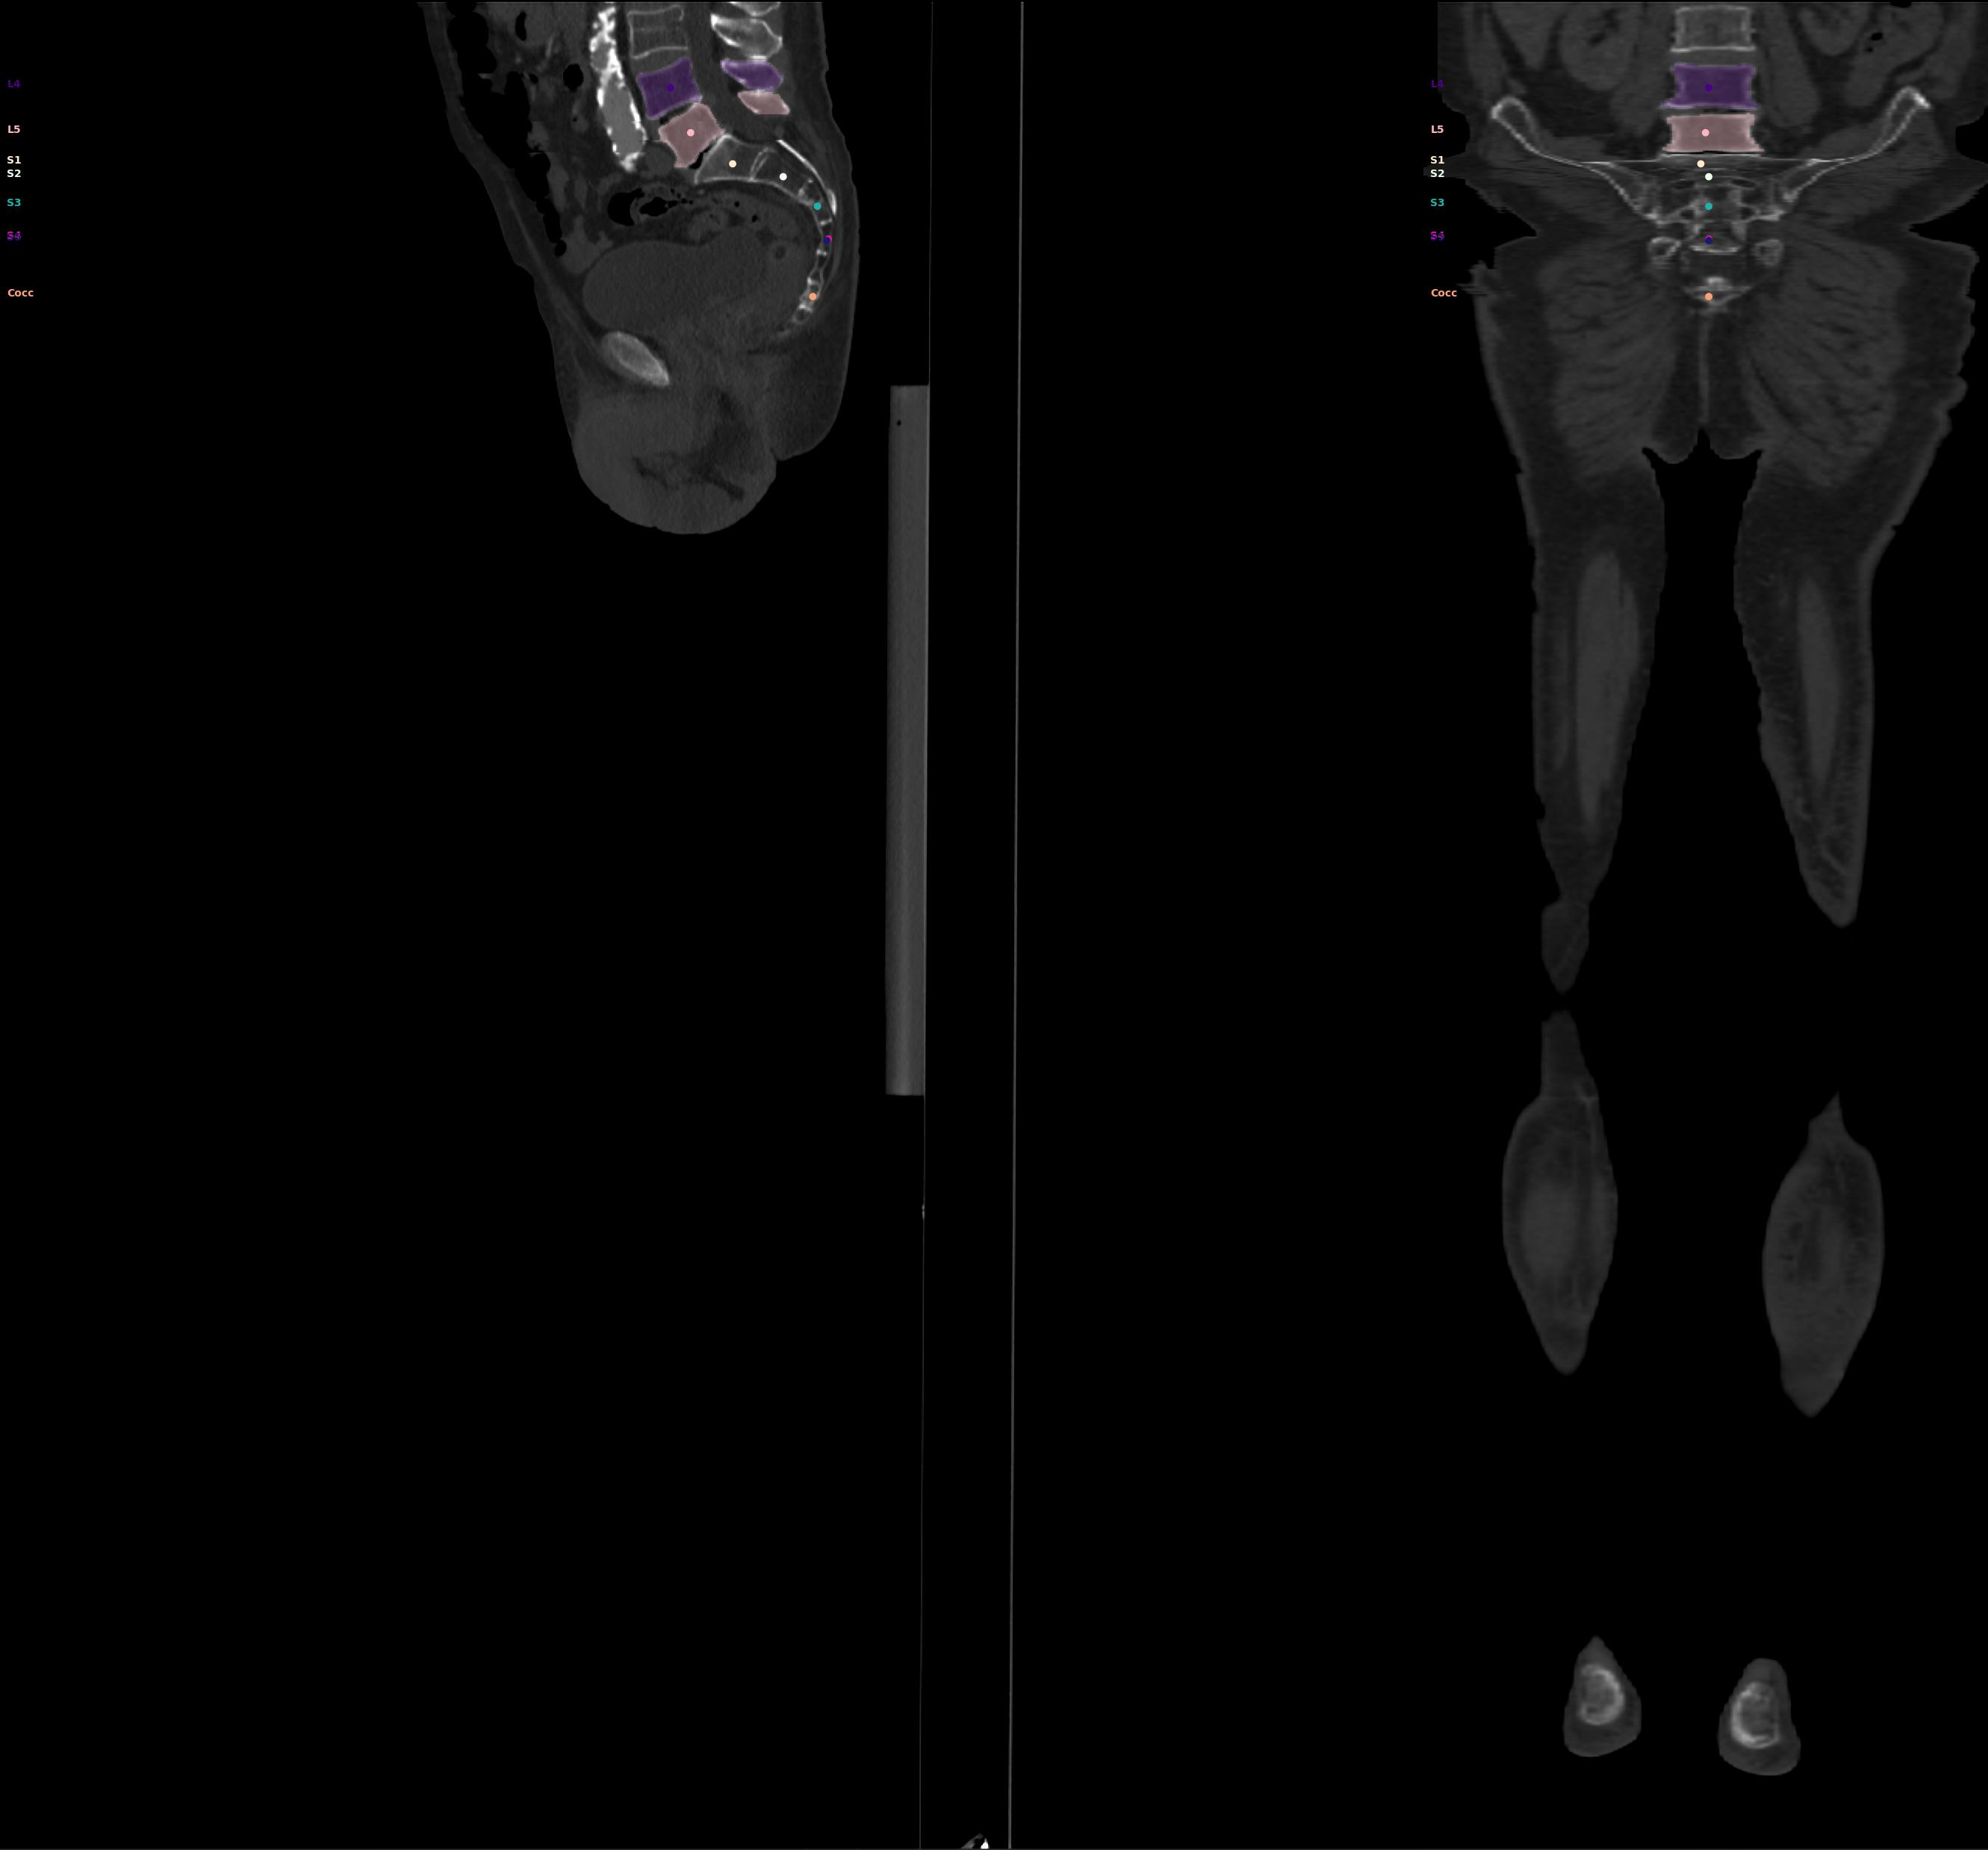

In [45]:
root = "/home/mamur/TUM/ADLM/dataset-verse19/"
ct_file = Path(root,"rawdata/sub-verse006/sub-verse006_ct.nii.gz")
vert_file = Path(root, 'derivatives/sub-verse006/sub-verse006_seg-vert_msk.nii.gz')
ctd_file = Path(root,"derivatives/sub-verse006/sub-verse006_seg-subreg_ctd.json")
out_file = Path('/tmp/out.jpg')
ct_frame = Snapshot_Frame(ct_file,segmentation=vert_file,centroids=ctd_file,sagittal=True,coronal=True,mode='CT')
create_snapshot(out_file,[ct_frame])
Image(filename=out_file)

In [ ]:
import numpy as np

def get_bounding_box(mask):
    x = np.any(mask, axis=(1, 2))
    y = np.any(mask, axis=(0, 2))
    z = np.any(mask, axis=(0, 1))

    xmin, xmax = np.where(x)[0][[0, -1]]
    ymin, ymax = np.where(y)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return xmin, xmax, ymin, ymax, zmin, zmax

# Load segmentation data (assuming it's a 3D numpy array)
seg_data = load_segmentation_data(snapshot_frame.segmentation)

# Identify lumbar vertebra and sacrum labels
lumbar_labels = [...]  # Replace with the actual label values for lumbar vertebra and sacrum

# Create a binary mask
mask = np.isin(seg_data, lumbar_labels)

# Calculate the bounding box
xmin, xmax, ymin, ymax, zmin, zmax = get_bounding_box(mask)

# Load the original image data (assuming it's a 3D numpy array)
img_data = load_image_data(snapshot_frame.image)

# Extract the ROI using the bounding box coordinates
roi = img_data[xmin:xmax+1, ymin:ymax+1, zmin:zmax+1]
